In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wobble

In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['figure.figsize'] = (12.0, 4.0)

#### First, you'll need some data to load up.

You can download example HARPS data files (and results files) to play around with linked in the [documentation](https://wobble.readthedocs.io/en/latest/quickstart.html#input-data).

Here we'll assume that you have the data `51peg_e2ds.hdf5` saved in the `wobble/data` directory.

By default, loading the data will load all echelle orders and all epochs in the data file; you can change this with the optional `orders` and `epochs` kwargs, which each take lists (or 1-d numpy arrays) of indices for the desired orders/epochs to load.

In [3]:
data = wobble.Data('../data/51peg_e2ds.hdf5')

Behind the scenes, we have also continuum normalized and masked out regions of bad data (negative flux values or very low SNR regions). You may want to take a look at the data to see how we did:

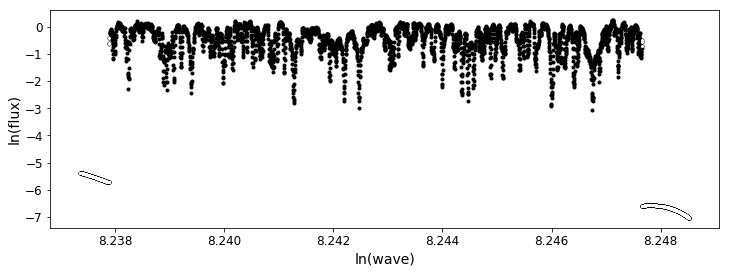

In [4]:
r = 0 # index of echelle order to plot
n = 0 # index of epoch to plot
plt.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
mask = data.ivars[r][n] <= 1.e-8 # masked-out bad data
plt.plot(data.xs[r][n][mask], data.ys[r][n][mask], 'w.', ms=4)
plt.ylabel('ln(flux)')
plt.xlabel('ln(wave)');

#### Now let's create a results object in which to store the outputs of wobble:

In [5]:
results = wobble.Results(data=data)

This object is not currently populated with useful information (because we haven't optimized anything yet!), but once it is we'll be able to save it with the `results.write('filename.hdf5')` function.

A saved results file can be loaded as:
```results = wobble.Results(filename='filename.hdf5')```

### Here's a minimal example of optimizing a model consisting of a star and tellurics for a single order:

In [6]:
r = 67 # index into data.orders for the desired order
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')
wobble.optimize_order(model)

Instructions for updating:
Colocations handled automatically by placer.


  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/91 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 91/91 [00:18<00:00,  4.97it/s]


The results have been automatically saved and we can now view them:

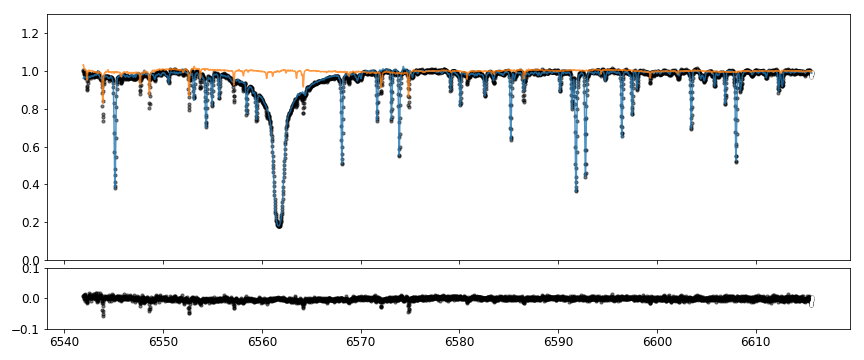

In [7]:
n = 40 # epoch to plot
results.plot_spectrum(r, n, data, 'demo1.png')
from IPython.display import Image
Image(filename='demo1.png') 

The residuals look good for the star but not great around the tellurics. Let's try running with variable tellurics.

In [8]:
results2 = wobble.Results(data=data)
model = wobble.Model(data, results2, r)
model.add_star('star')
model.add_telluric('tellurics', variable_bases=2)
wobble.optimize_order(model)

  0%|          | 0/100 [00:00<?, ?it/s]

optimize: iterating through 100 optimization steps...


  0%|          | 0/91 [00:00<?, ?it/s]

optimize: calculating uncertainties on star rvs...


100%|██████████| 91/91 [00:15<00:00,  6.05it/s]


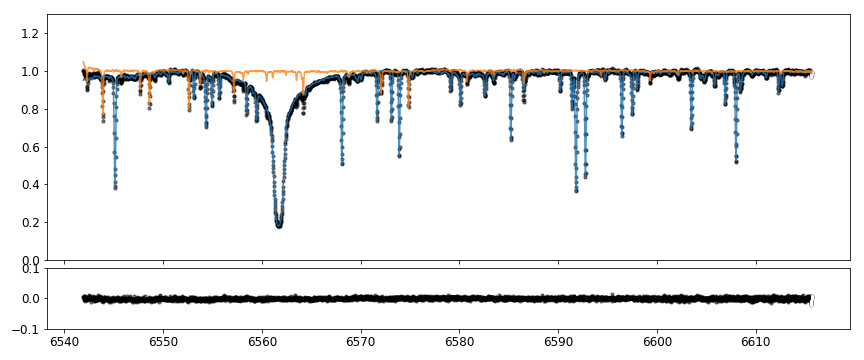

In [10]:
results2.plot_spectrum(r, n, data, 'demo2.png')
from IPython.display import Image
Image(filename='demo2.png') 

Looks better! Here are the RVs for this single order. Once we run on all orders, we can combine the order-by-order velocities using `results.combine_orders('star')` and access the final (non-barycentric-corrected RVs as `results.star_time_rvs`.

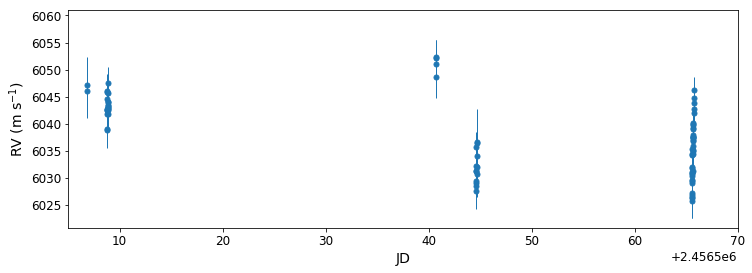

In [11]:
plt.errorbar(results2.dates, results2.star_rvs[r] + results2.bervs, 
             1./np.sqrt(results2.star_ivars_rvs[r]), 
             fmt='o', ms=5, elinewidth=1)
plt.xlabel('JD')
plt.ylabel(r'RV (m s$^{-1}$)')
plt.xlim([2456505, 2456570]);

### Now let's generalize this to multiple orders and get RVs for the full spectrum:

In the following loop, we'll continually be overwriting the "model" variable. That's ok! All optimized results will be copied over to the "results" object automatically, and as long as the star component is given the same name in the model for every order, they'll be associated in the results object as we'd expect.

In [ ]:
results = wobble.Results(data=data)
for r in range(len(data.orders)):
        model = wobble.Model(data, results, r)
        model.add_star('star')
        model.add_telluric('tellurics')
        wobble.optimize_order(model)

Now that we have RVs, let's do some post-processing on them:

In [ ]:
results.combine_orders('star')
results.apply_drifts('star') # instrumental drift corrections
results.apply_bervs('star') # barycentric corrections

Finally, we can look at the resulting RVs and save them to a text file:

In [ ]:
plt.errorbar(data.dates, results.star_time_rvs - np.mean(results.star_time_rvs), 
                     result.star_time_sigmas,
                    fmt='o', ms=5, elinewidth=1)
plt.set_ylabel('JD')
plt.set_xlabel(r'RV (m s$^{-1}$)');

In [ ]:
results.write_rvs('star', 'rvs.csv')

### Further exercises:
- [optimize the regularization amplitudes](https://github.com/megbedell/wobble/blob/master/scripts/regularization.py) and rerun
- check [the API](https://wobble.readthedocs.io/en/latest/api.html) and figure out what keywords to use if you want to:
    - calculate uncertainties on the stellar template (warning: this will run slowly)
    - give your own custom starting RV guess to a component